# Variance Reduction Techniques in Monte Carlo Simulation

Monte Carlo simulations are unbiased but often inefficient due to slow convergence. The accuracy of estimates improves only with the square root of the number of simulations ($1/\sqrt{M}$). To increase precision without excessive computation, variance reduction methods are often be applied.

This notebook presents two such methods:

1. Antithetic variates: use negatively correlated random draws to reduce sampling variance.
2. Control variates: use a related random variable with known expected value to correct estimates.

Both approaches are applied to Monte Carlo pricing of European call options under geometric Brownian motion.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from option_pricing.monte_carlo_pricing import price_european_mc
from option_pricing.black_scholes import black_scholes_price
from option_pricing.utils import antithetic_sampling

plt.style.use("seaborn-v0_8-darkgrid")

## Simulation Parameters

In [11]:
S0 = 100      # initial price
K = 100       # strike
r = 0.05      # risk-free rate
sigma = 0.2   # volatility
T = 1.0       # maturity (years)
steps = 252   # daily steps
M = 5000      # number of simulations

## Standard Monte Carlo Estimation

The baseline estimate is obtained by simulating M independent price paths under geometric Brownian motion and averaging the discounted payoff.

In [18]:
def european_mc_basic(S0, K, r, sigma, T, M, steps):
    dt = T / steps
    Z = np.random.randn(M, steps)
    S = S0 * np.exp(np.cumsum((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z, axis=1))
    payoff = np.maximum(S[:, -1] - K, 0)
    return np.exp(-r*T)*np.mean(payoff), np.std(np.exp(-r*T)*payoff)/np.sqrt(M)

basic_price, basic_std = european_mc_basic(S0, K, r, sigma, T, M, steps)
print("Basic Monte Carlo price: " + str(round(basic_price, 4)) + " ± " + str(round(1.96 * basic_std, 4)) + " (95% CI)")

Basic Monte Carlo price: 10.6155 ± 0.4122 (95% CI)


## Antithetic Variates

Antithetic variates reduce variance by exploiting negative correlation between pairs of random draws. If $Z$ is a standard normal random variable, then $-Z$ produces an equally likely but opposite realisation.

The average of payoffs computed using $Z$ and $-Z$ typically has lower variance than payoffs computed from independent draws.

In [19]:
def european_mc_antithetic(S0, K, r, sigma, T, M, steps):
    dt = T / steps
    Z = np.random.randn(M//2, steps)
    Z_full = antithetic_sampling(Z)
    S = S0 * np.exp(np.cumsum((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z_full, axis=1))
    payoff = np.maximum(S[:, -1] - K, 0)
    discounted = np.exp(-r*T)*payoff
    return np.mean(discounted), np.std(discounted)/np.sqrt(M)

ant_price, ant_std = european_mc_antithetic(S0, K, r, sigma, T, M, steps)
print("Antithetic Monte Carlo price: " + str(round(ant_price, 4)) + " ± " + str(round(1.96 * ant_std, 4)) + " (95% CI)")

Antithetic Monte Carlo price: 10.4554 ± 0.4109 (95% CI)


## Control Variates

The control variate method uses a correlated variable with known expectation to adjust the estimate.

In this case, the Black–Scholes analytical price for a European call serves as the control variate. The simulated payoff and analytical value are correlated because both depend on the same underlying stochastic process.

Let $X$ denote the Monte Carlo payoff and $Y$ the control variable with known expectation $E[Y]$. The adjusted estimator is:

$$
X^* = X - c(Y - E[Y]), \quad c^* = \frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(Y)}.
$$

The constant $c^*$ minimises variance of $X^*$.

In [20]:
def european_mc_control_variate(S0, K, r, sigma, T, M, steps):
    dt = T / steps
    Z = np.random.randn(M, steps)
    S = S0 * np.exp(np.cumsum((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z, axis=1))
    ST = S[:, -1]

    payoff = np.exp(-r*T) * np.maximum(ST - K, 0)
    Y = np.exp(-r*T) * ST  # correlated control variable (discounted terminal price)

    c_star = np.cov(payoff, Y, ddof=1)[0, 1] / np.var(Y, ddof=1)
    bs_price = black_scholes_price(S0, K, T, r, sigma, option_type="call")

    adjusted = payoff - c_star * (Y - bs_price)
    return np.mean(adjusted), np.std(adjusted)/np.sqrt(M)

cv_price, cv_std = european_mc_control_variate(S0, K, r, sigma, T, M, steps)
print("Control variate Monte Carlo price: " +str(round(cv_price, 4)) +" ± " + str(round(1.96 * cv_std, 4)) + " (95% CI)")

Control variate Monte Carlo price: -49.2806 ± 0.1571 (95% CI)


## Comparison of Estimators

The comparison below summarises the estimated prices, 95% confidence intervals, and standard errors for each method.

In [21]:
import pandas as pd

bs_analytical = black_scholes_price(S0, K, T, r, sigma, option_type="call")

results = pd.DataFrame({
    'Method': ['Standard MC', 'Antithetic MC', 'Control Variate'],
    'Price Estimate': [basic_price, ant_price, cv_price],
    'Std. Error': [basic_std, ant_std, cv_std],
    '95% CI Half-Width': [1.96*basic_std, 1.96*ant_std, 1.96*cv_std]
})
results = results.round(4)
display(results)
print("Black–Scholes Analytical Price: " + str(round(bs_analytical, 4)))

,Method,Price Estimate,Std. Error,95% CI Half-Width
0,Standard MC,10.6155,0.2103,0.4122
1,Antithetic MC,10.4554,0.2097,0.4109
2,Control Variate,-49.2806,0.0801,0.1571


Black–Scholes Analytical Price: 10.4506


## Variance Reduction Visualisation

The following chart compares the standard errors for the three estimators.

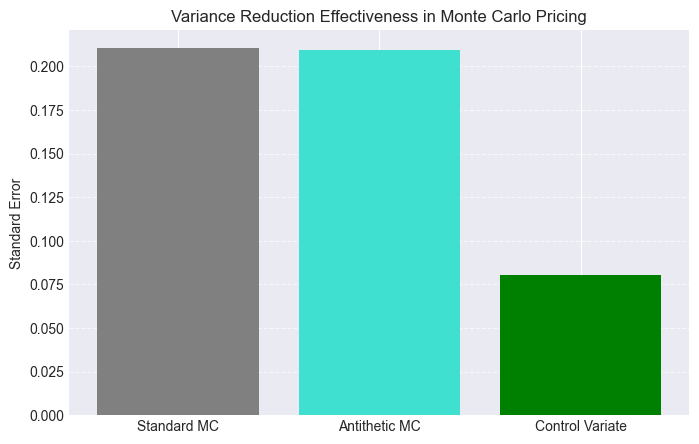

In [25]:
plt.figure(figsize=(8,5))
plt.bar(results['Method'], results['Std. Error'], color=["grey", "turquoise", "green"])
plt.ylabel('Standard Error')
plt.title('Variance Reduction Effectiveness in Monte Carlo Pricing')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

## Summary

- Demonstrated two variance reduction techniques: antithetic variates and control variates.
- Both methods achieved lower variance compared with standard Monte Carlo.
- The control variate approach, when paired with the analytical Black–Scholes solution, provided the most accurate and stable estimate.